# G<sup>2</sup>-Force Calibration

This notebook demonstrates the (approximate) conversion between gradient squared values and forces for a given photoelastic setup, characterized by:

1. $f_\sigma$ (Photoelastic stress coefficient)
2. px/m (pixels/meter)
3. Brightfield or darkfield specification
4. Radius of particle



In [1]:
# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import circularMask, mergeMasks
from pepe.simulate import genSyntheticResponse
from pepe.analysis import g2ForceCalibration, g2ForceCalibrationDebug, gSquared

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

# For timing
import time

## Basic Calculation

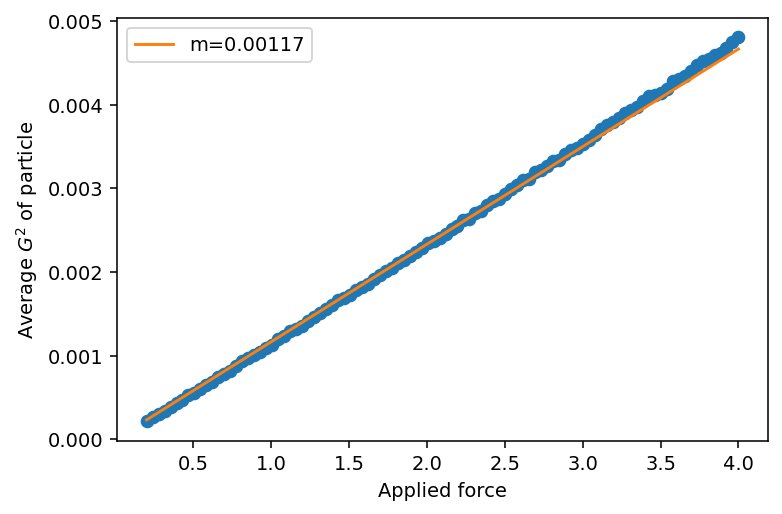

In [2]:
radiusM = .01
radius = 200 # px
pxPerMeter = radius / radiusM #10000
fSigma = 100

slope = g2ForceCalibration(fSigma, radius, pxPerMeter, brightfield=False, forceBounds=np.array([0.1, 2]))

forceArr, g2Arr = g2ForceCalibrationDebug(fSigma, radius, pxPerMeter, brightfield=False, forceBounds=np.array([0.1, 2]))
plt.plot(forceArr, g2Arr, 'o-')
plt.plot(forceArr, slope*forceArr, label=f'm={slope:.3}')

plt.legend()
plt.xlabel('Applied force')
plt.ylabel(r'Average $G^2$ of particle')
plt.show()

## Diametric Force Estimation

Now we can use the calibration value to try and find an "unknown" force acting on a particle. 

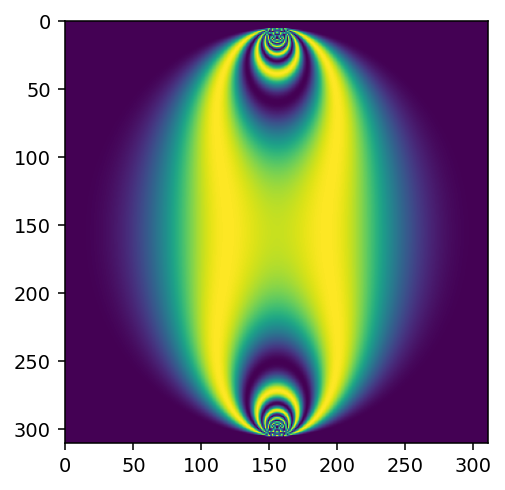

Estimated force magnitude:   0.7015
Actual force magnitude:      0.7


In [12]:
betaArr = np.array([0., np.pi])
alphaArr = np.array([0., 0.])
forceArr = np.array([.7, .7]) # What we will consider to be "unknown"
fSigma = 100
radius = 150
pxPerMeter = 10000
brightfield = False

g2Cal = g2ForceCalibration(fSigma, radius, pxPerMeter, brightfield=brightfield, forceBounds=np.array([0.1, 2]))
synImage = genSyntheticResponse(forceArr, alphaArr, betaArr, fSigma, radius, pxPerMeter, brightfield)

plt.imshow(synImage)
plt.show()

particleMask = circularMask(synImage.shape, np.array(synImage.shape[:2])/2, radius)[:,:,0]

gSqr = gSquared(synImage)

avgGSqr = np.sum(gSqr * particleMask) / np.sum(particleMask)

estimatedForce = avgGSqr / g2Cal / 2

print(f'Estimated force magnitude:   {estimatedForce:.4}')
print(f'Actual force magnitude:      {forceArr[0]}')

## Arbitrary Force Estimation

The previous example just estimated the total force on the particle, and then we input the knowledge that there were two equal diametric forces to find the magnitude. This example will generalize and try to identify two distinct force magnitudes.

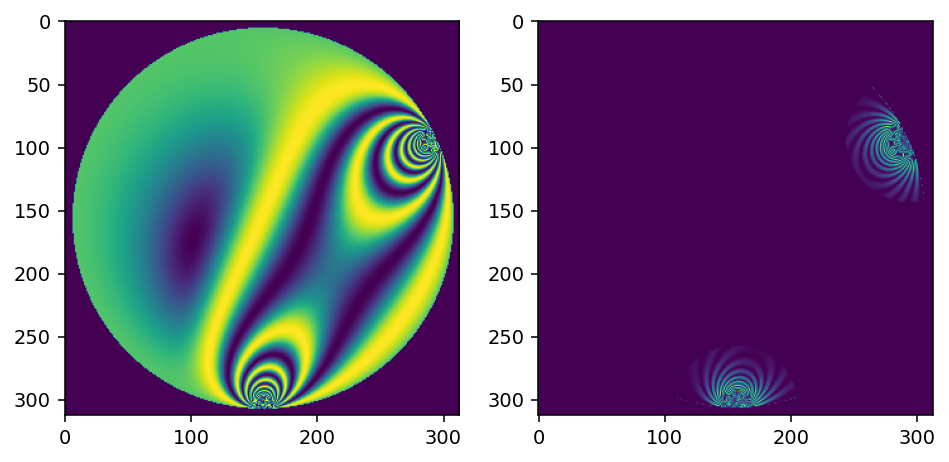

Estimated force magnitudes:   [1.53412443 1.93544368]
Actual force magnitudes:      [1.2 1.6]


In [10]:
betaArr = np.array([0., 2.]) # No longer diametric
alphaArr = np.array([0., 0.])
forceArr = np.array([1.2, 1.6]) # No longer equal
fSigma = 100
radius = 151
pxPerMeter = 10000
brightfield = False

fig, ax = plt.subplots(1, 2, figsize=(8,5))

g2Cal = g2ForceCalibration(fSigma, radius, pxPerMeter, brightfield=brightfield, forceBounds=np.array([0.1, 2]))
synImage = genSyntheticResponse(forceArr, alphaArr, betaArr, fSigma, radius, pxPerMeter, brightfield)

ax[0].imshow(synImage)

particleMask = circularMask(synImage.shape, np.array(synImage.shape[:2])/2, radius)[:,:,0]
g2Mask = circularMask(synImage.shape, np.array(synImage.shape[:2])/2, radius-1)[:,:,0]

gSqr = gSquared(synImage)

avgGSqr = np.sum(gSqr * particleMask) / np.sum(particleMask)

# Instead of just dividing by 2 here, we have to find the proportion of force
# that should be allocated to each contact

contactRadius = 50
contactG2Arr = np.zeros(len(betaArr))
totalContactMask = np.zeros_like(synImage)
# Now we have to find the average gsqr at each contact
for i in range(len(betaArr)):
    contactMask = circularMask(synImage.shape,
                               np.array(synImage.shape[:2])/2 + radius*np.array([np.cos(betaArr[i]), np.sin(betaArr[i])]),
                              contactRadius)[:,:,0]
    # Now make sure it stays within the particle
    contactMask = 1 - np.int16((contactMask + g2Mask - 2) > 0)
    
    totalContactMask += contactMask
    
    contactG2Arr[i] = np.sum(gSqr * contactMask) / np.sum(contactMask)

estimatedForceArr = avgGSqr * contactG2Arr / np.sum(contactG2Arr) / g2Cal

ax[1].imshow(totalContactMask * gSqr)
plt.show()

print(f'Estimated force magnitudes:   {estimatedForceArr}')
print(f'Actual force magnitudes:      {forceArr}')

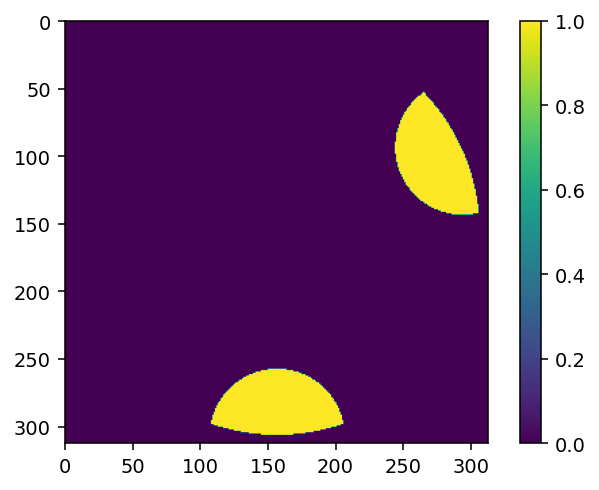

In [6]:
plt.imshow(totalContactMask)
plt.colorbar()
plt.show()

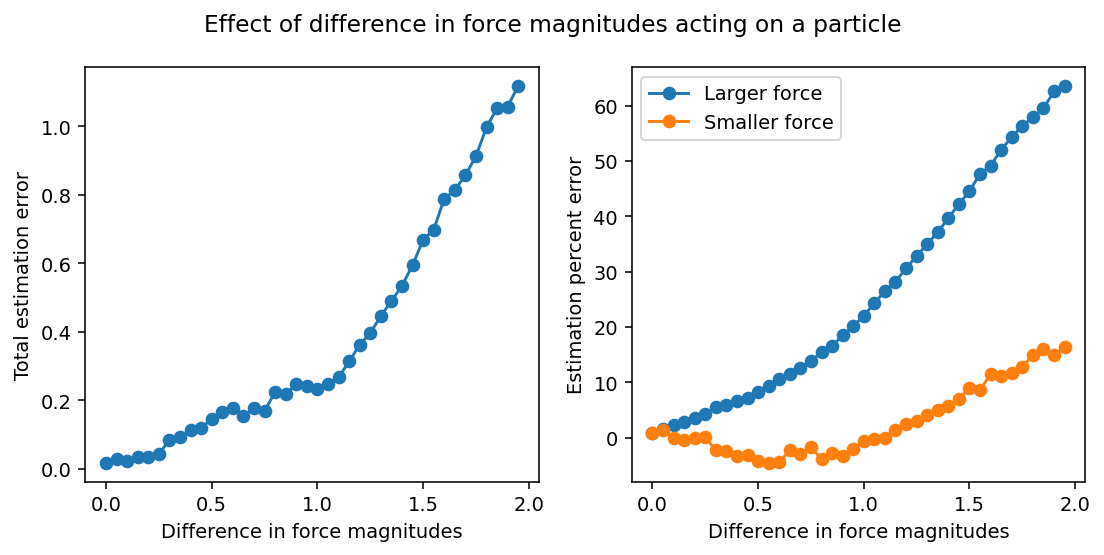

In [8]:
betaArr = np.array([0., np.pi]) # No longer diametric
alphaArr = np.array([0., 0.])
fSigma = 100
radius = 151
pxPerMeter = 10000
brightfield = False

g2Cal = g2ForceCalibration(fSigma, radius, pxPerMeter, brightfield=brightfield, forceBounds=np.array([0.1, 2]))

steps = 40

forceError = np.zeros(steps)
forceDifference = np.zeros(steps)
forceErrorIndv = np.zeros((steps, 2))

forceArr = np.zeros((steps, 2))
estimatedForceArr = np.zeros((steps, 2))

for j in range(steps):
    forceArr[j] = np.array([1., 1. + float(j)/20.])

    synImage = genSyntheticResponse(forceArr[j], alphaArr, betaArr, fSigma, radius, pxPerMeter, brightfield)

    particleMask = circularMask(synImage.shape, np.array(synImage.shape[:2])/2, radius)[:,:,0]
    g2Mask = circularMask(synImage.shape, np.array(synImage.shape[:2])/2, radius-1)[:,:,0]

    gSqr = gSquared(synImage)

    avgGSqr = np.sum(gSqr * particleMask) / np.sum(particleMask)

    # Instead of just dividing by 2 here, we have to find the proportion of force
    # that should be allocated to each contact

    contactRadius = 50
    contactG2Arr = np.zeros(len(betaArr))
    totalContactMask = np.zeros_like(synImage)
    # Now we have to find the average gsqr at each contact
    for i in range(len(betaArr)):
        contactMask = circularMask(synImage.shape,
                                   np.array(synImage.shape[:2])/2 + radius*np.array([np.cos(betaArr[i]), np.sin(betaArr[i])]),
                                  contactRadius)[:,:,0]
        # Now make sure it stays within the particle
        contactMask = 1 - np.int16((contactMask + g2Mask - 2) > 0)

        totalContactMask += contactMask

        contactG2Arr[i] = np.sum(gSqr * contactMask) / np.sum(contactMask)

    estimatedForceArr[j] = avgGSqr * contactG2Arr / np.sum(contactG2Arr) / g2Cal

    forceDifference[j] = forceArr[j,1] - forceArr[j,0]
    forceError[j] = np.sum(np.abs(estimatedForceArr[j] - forceArr[j]))
    forceErrorIndv[j] = np.abs(estimatedForceArr[j] - forceArr[j]) / forceArr[j] * 100.
    
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(forceDifference, forceError, '-o')
ax[0].set_xlabel('Difference in force magnitudes')
ax[0].set_ylabel('Total estimation error')

ax[1].plot(forceDifference, 100 * (-forceArr[:,0] + estimatedForceArr[:,0]) / forceArr[:,0], '-o', label='Larger force')
ax[1].plot(forceDifference, 100 * (-forceArr[:,1] + estimatedForceArr[:,1]) / forceArr[:,1], '-o', label='Smaller force')

ax[1].set_ylabel('Estimation percent error')
ax[1].set_xlabel('Difference in force magnitudes')
ax[1].legend()

fig.suptitle('Effect of difference in force magnitudes acting on a particle')
fig.tight_layout()
#plt.savefig('force_diff_estimation.png')
plt.show()

As the two forces on the object become further in magnitude from each other, the estimation of the force becomes less accurate. Since this method is only used to generate the initial guess, this isn't the biggest problem, but it may be worth looking into at some point.